In [5]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from PIL import Image

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the saved model state dict
path = r'model_path.pth'
pretrained_vit_state_dict = torch.load(path, map_location=device)

# Setup a ViT model instance with pretrained weights
pretrained_vit = models.vit_b_16().to(device)

# Rename the keys in the loaded state dict to match the keys in the model's state dict
new_pretrained_vit_state_dict = {}
for k, v in pretrained_vit_state_dict.items():
    if 'head' in k:
        k = k.replace('head', 'heads')  # Rename keys related to the classifier head
    new_pretrained_vit_state_dict[k] = v

pretrained_vit.load_state_dict(new_pretrained_vit_state_dict, strict=False)

# Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# Change the classifier head
class_names = ['benign', 'malignant', 'normal']
pretrained_vit.conv_proj.in_channels = 3
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

# Load the image
image_path = r"DATASET\test\malignant\malignant347.png"
image = Image.open(image_path).convert('RGB')

# Define the transformations for the input image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Preprocess the image
input_image = transform(image).unsqueeze(0).to(device)

# Set the model to evaluation mode
pretrained_vit.eval()

# Make prediction
with torch.no_grad():
    outputs = pretrained_vit(input_image)

# Get predicted class index
_, predicted = torch.max(outputs, 1)

# Map the predicted index to class label
predicted_class = class_names[predicted.item()]
print("Predicted class:", predicted_class)


# prediction using the scratch model

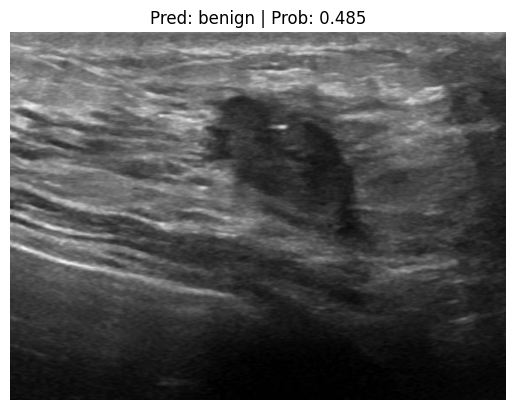

In [22]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from typing import List, Tuple

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Define the PatchEmbedding class
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels:int=3, patch_size:int=16, embedding_dim:int=768):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels, embedding_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        return x

# Define the MultiheadSelfAttentionBlock class
class MultiheadSelfAttentionBlock(nn.Module):
    def __init__(self, embedding_dim:int=768, num_heads:int=12, attn_dropout:float=0):
        super().__init__()
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=num_heads, dropout=attn_dropout, batch_first=True)

    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, key=x, value=x, need_weights=False)
        return attn_output

# Define the MLPBlock class
class MLPBlock(nn.Module):
    def __init__(self, embedding_dim:int=768, mlp_size:int=3072, dropout:float=0.1):
        super().__init__()
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )

    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

# Define the TransformerEncoderBlock class
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embedding_dim:int=768, num_heads:int=12, mlp_size:int=3072, mlp_dropout:float=0.1, attn_dropout:float=0):
        super().__init__()
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim, num_heads=num_heads, attn_dropout=attn_dropout)
        self.mlp_block = MLPBlock(embedding_dim=embedding_dim, mlp_size=mlp_size, dropout=mlp_dropout)

    def forward(self, x):
        x = self.msa_block(x) + x
        x = self.mlp_block(x) + x
        return x

# Define the ViT class
class ViT(nn.Module):
    def __init__(self, img_size:int=224, in_channels:int=3, patch_size:int=16, num_transformer_layers:int=12, embedding_dim:int=768, mlp_size:int=3072, num_heads:int=12, attn_dropout:float=0, mlp_dropout:float=0.1, embedding_dropout:float=0.1, num_classes:int=2):
        super().__init__()
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."
        self.num_patches = (img_size * img_size) // patch_size**2
        self.class_token = nn.Parameter(data=torch.randn(1, 1, embedding_dim), requires_grad=True)
        self.pos_embedding = nn.Parameter(data=torch.randn(1, self.num_patches + 1, embedding_dim), requires_grad=True)
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        self.patch_embedding = PatchEmbedding(in_channels=in_channels, patch_size=patch_size, embedding_dim=embedding_dim)
        self.encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim, num_heads=num_heads, mlp_size=mlp_size, mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
        self.ln = nn.LayerNorm(normalized_shape=embedding_dim)
        self.heads = nn.Linear(in_features=embedding_dim, out_features=num_classes)

    def forward(self, x):
        batch_size = x.shape[0]
        class_token = self.class_token.expand(batch_size, -1, -1)
        x = self.patch_embedding(x)
        x = torch.cat((class_token, x), dim=1)
        x = self.pos_embedding + x
        x = self.embedding_dropout(x)
        x = self.encoder(x)
        x = self.ln(x[:, 0])
        x = self.heads(x)
        return x

# Function to predict and plot an image
def pred_and_plot_image(
    model: torch.nn.Module,
    class_names: List[str],
    image_path: str,
    image_size: Tuple[int, int] = (224, 224),
    transform: transforms.transforms = None,
    device: torch.device = device,
):
    """Predicts on a target image with a target model and plots the result."""
    # Open image
    img = Image.open(image_path).convert('RGB')

    # Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ###

    # Make sure the model is on the target device
    model.to(device)

    # Turn on model evaluation mode
    model.eval()

    # Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
    transformed_image = image_transform(img).unsqueeze(dim=0)

    # Make a prediction on image with an extra dimension and send it to the target device
    with torch.inference_mode():
        target_image_pred = model(transformed_image.to(device))

    # Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False)
    plt.show()

# Load the model
model_path = r"mo"
model = ViT(num_classes=3)  # Adjust the number of classes as needed
# model.load_state_dict(torch.load(model_path, map_location=device))
pretrained_vit_state_dict = torch.load(model_path,map_location=device)

new_pretrained_vit_state_dict = {}
for k, v in pretrained_vit_state_dict.items():
    # print(k,"     --->     ",v)
    if 'head' in k:
        # print("replaced   ",k )
        k = k.replace('head', 'heads')  # Rename keys related to the classifier head
    new_pretrained_vit_state_dict[k] = v

model.load_state_dict(new_pretrained_vit_state_dict,strict=False)

model.to(device)
model.eval()

# Define class names
class_names = ["benign", "malignant","normal"]

# Image path
image_path = r"image_path"

# Predict and plot
pred_and_plot_image(model, class_names, image_path)
